# Training a baseline classifier

Train a simple baseline classifier for predicting the sentence class in the eduskunta-vkk data.

See the [README](../README.md) for a description of the dataset.

In [2]:
%matplotlib inline

import re
from voikko import libvoikko
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, roc_auc_score,\
    confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MaxAbsScaler, LabelEncoder
from sklearn.svm import LinearSVC, SVC

In [3]:
plt.rcParams["figure.figsize"] = (20, 10)

In [4]:
split_whitespace_re = re.compile(r"(?u)\b\w\w+\b")

def get_pipeline(n_dim=500, classifier='svc', reducer=None):
    vectorizer = TfidfVectorizer(tokenizer=tokenizer,
                                 ngram_range=(1, 2),
                                 max_df=0.1,
                                 stop_words=stop_words_fi)
    steps = [('vectorizer', vectorizer)]
    
    if reducer == 'svd':
        steps.append(('dimensionality_reduction', TruncatedSVD(n_dim)))
    elif reducer == 'chi2':
        steps.append(('dimensionality_reduction', SelectKBest(chi2, k=n_dim)))
    elif reducer:
        assert False, 'Unknown reducer'

    steps.append(('scaler', MaxAbsScaler()))

    if classifier == 'logreg':
        steps.append(('classifier', LogisticRegression(multi_class='multinomial', max_iter=1000)))
    elif classifier == 'svc':
        steps.append(('classifier', LinearSVC(loss='hinge', intercept_scaling=5.0,
                                              max_iter=100000, multi_class='ovr')))
    elif classifier:
        assert False, 'Unknown classifier'
    
    return Pipeline(steps)

def build_voikko_tokenizer(voikko):
    def tokenizer(text):
        tokens = []
        for w in split_whitespace_re.findall(text):
            analyzed = voikko.analyze(w)

            if analyzed:
                token = analyzed[0].get('BASEFORM', w)
            else:
                token = w

            tokens.append(token.lower())

        return tokens

    return tokenizer


voikko = libvoikko.Voikko('fi')
tokenizer = build_voikko_tokenizer(voikko)
stop_words_fi = list(set(tokenizer(t)[0] for t in [
    'ei', 'että', 'he', 'hän', 'ja', 'joka', 'jos', 'koska', 'kuin', 'kuka',
    'kun', 'me', 'mikä', 'minä', 'myös', 'ne', 'nuo', 'nämä', 'olla', 'se',
    'sinä', 'tai', 'te', 'tuo', 'tämä', 'vai',
]))

## Load data

In [5]:
def load_documents(filename):
    return pd.read_csv(filename, header=0).rename(columns={'ministry': 'class'})

def load_data():
    train = load_documents('../vkk/train.csv.bz2')
    dev = load_documents('../vkk/dev.csv.bz2')
    test = load_documents('../vkk/test.csv.bz2')
    
    return train, dev, test

In [6]:
train, dev, test = load_data()
print(f'Number of train samples: {len(train)}')
print(f'Number of dev samples: {len(dev)}')
print(f'Number of test samples: {len(test)}')

Number of train samples: 49106
Number of dev samples: 3000
Number of test samples: 3000


In [7]:
short_names = {
    'perhe- ja peruspalveluministeri': 'per',
    'maatalous- ja ympäristöministeri': 'maa',
    'sisäministeri': 'sis',
    'oikeus- ja työministeri': 'oik',
    'opetus- ja kulttuuriministeri': 'ope',
    'valtiovarainministeri': 'val',
    'liikenne- ja viestintäministeri': 'lii',
    'sosiaali- ja terveysministeri': 'sos',
    'elinkeinoministeri': 'eli',
    'ulkoministeri': 'ulk',
    'kunta- ja uudistusministeri': 'kun',
    'eurooppa-, kulttuuri- ja urheiluministeri': 'eur',
    'pääministeri': 'pää',
    'puolustusministeri': 'puo',
    'ulkomaankauppa- ja kehitysministeri': 'uke',
}

## Explore tokens that separate one class from the others

In [8]:
count_vectorizer = CountVectorizer(tokenizer=tokenizer, min_df=10, stop_words=stop_words_fi)
counts = count_vectorizer.fit_transform(train['sentence'], train['class'])

In [9]:
def get_discriminating_indexes(k, counts, count_vectorizer):
    res = {}
    for c in train['class'].unique():
        y = train['class'] == c
        scores, _ = chi2(counts, y)
        res[c] = np.argsort(-scores)[:k]

    return res

def print_discriminating_words(k, counts, count_vectorizer):
    discriminating = get_discriminating_indexes(k, counts, count_vectorizer)
    word_frequencies = counts.sum(axis=0)
    tokens = count_vectorizer.get_feature_names()
    for class_name, inds in discriminating.items():
        print(class_name)
        print('-'*30)
        print('\n'.join(f'{tokens[i]} ({word_frequencies[0, i]})' for i in inds))
        print()

print_discriminating_words(20, counts, count_vectorizer)

sisäministeri
------------------------------
poliisi (838)
maahanmuuttovirasto (421)
sisäministeriö (290)
turvapaikanhakija (416)
ulkomaalaislaki (180)
vastaanottokeskus (260)
suojelu (477)
poliisihallitus (141)
oleskelulupa (255)
poliisilaitos (116)
hakija (547)
ulkomaalainen (202)
turvapaikka (130)
palauttaa (176)
turvapaikkahakemus (91)
poliisimies (61)
rajavartiolaitos (91)
maahantulo (73)
kansainvälistää (218)
irak (104)

oikeus- ja työministeri
------------------------------
työnhakija (263)
oikeusministeriö (318)
velallinen (161)
palkkatuki (128)
työtön (282)
työllistyä (322)
työ (1683)
toimisto (204)
rikoslaki (166)
työttömyysetuus (264)
henkilötieto (116)
käräjäoikeus (86)
palkkatuettu (60)
yritystoiminta (203)
suojaosuus (59)
rangaistava (104)
työvoima (163)
törkeä (87)
luku (555)
elinkeinotoimisto (91)

maatalous- ja ympäristöministeri
------------------------------
metsätalousministeriö (310)
eläin (327)
metsähallitus (228)
metsä (177)
metsästys (175)
susi (161)
ympäristömi

## Train a classifier

Train a linear SVM. Learn the SVM regularization parameter by cross-validation on the training set. The multiclass predictions are summarized by a weighted F1 score.

In [10]:
grid = {'classifier__C': [1e-2, 1e-1, 1]}
pipe = get_pipeline(classifier='svc')

enc = LabelEncoder()
y_encoded = enc.fit_transform(train['class'])

gridsearch = GridSearchCV(pipe, grid, cv=5, scoring='f1_weighted', refit=True, n_jobs=1, verbose=2)
gridsearch.fit(train['sentence'], y_encoded)
clf = gridsearch.best_estimator_

gridsearch.cv_results_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] classifier__C=0.01 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................... classifier__C=0.01, total=  36.2s
[CV] classifier__C=0.01 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.2s remaining:    0.0s


[CV] ............................... classifier__C=0.01, total=  36.0s
[CV] classifier__C=0.01 ..............................................
[CV] ............................... classifier__C=0.01, total=  38.0s
[CV] classifier__C=0.01 ..............................................
[CV] ............................... classifier__C=0.01, total=  35.9s
[CV] classifier__C=0.01 ..............................................
[CV] ............................... classifier__C=0.01, total=  37.0s
[CV] classifier__C=0.1 ...............................................
[CV] ................................ classifier__C=0.1, total=  47.2s
[CV] classifier__C=0.1 ...............................................
[CV] ................................ classifier__C=0.1, total=  46.9s
[CV] classifier__C=0.1 ...............................................
[CV] ................................ classifier__C=0.1, total=  45.9s
[CV] classifier__C=0.1 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 12.8min finished


{'mean_fit_time': array([31.54057875, 41.71295471, 65.5703629 ]),
 'std_fit_time': array([0.83570786, 1.03813305, 2.84259694]),
 'mean_score_time': array([5.07294965, 4.99689784, 4.99606867]),
 'std_score_time': array([0.14822823, 0.02714751, 0.14054626]),
 'param_classifier__C': masked_array(data=[0.01, 0.1, 1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'classifier__C': 0.01},
  {'classifier__C': 0.1},
  {'classifier__C': 1}],
 'split0_test_score': array([0.67913941, 0.70862327, 0.69616344]),
 'split1_test_score': array([0.6765328 , 0.70936675, 0.69887373]),
 'split2_test_score': array([0.68204752, 0.71596557, 0.70157058]),
 'split3_test_score': array([0.68477533, 0.71671198, 0.7030204 ]),
 'split4_test_score': array([0.68385035, 0.71561636, 0.69835516]),
 'mean_test_score': array([0.68126908, 0.71325679, 0.69959666]),
 'std_test_score': array([0.00305059, 0.00350558, 0.00242773]),
 'rank_test_score': array([3, 1, 2], dt

## Evaluation on the test set

In [11]:
X_test = test['sentence']
y_test_true = test['class']
y_test_pred = enc.inverse_transform(clf.predict(X_test))

print(classification_report(y_test_true, y_test_pred))

                                           precision    recall  f1-score   support

                       elinkeinoministeri       0.63      0.50      0.56       104
eurooppa-, kulttuuri- ja urheiluministeri       0.72      0.61      0.66        51
              kunta- ja uudistusministeri       0.66      0.38      0.48        56
          liikenne- ja viestintäministeri       0.77      0.77      0.77       231
         maatalous- ja ympäristöministeri       0.77      0.83      0.80       450
                  oikeus- ja työministeri       0.64      0.68      0.66       362
            opetus- ja kulttuuriministeri       0.80      0.82      0.81       348
          perhe- ja peruspalveluministeri       0.68      0.76      0.71       480
                       puolustusministeri       0.83      0.64      0.72        39
                             pääministeri       0.63      0.48      0.55        54
                            sisäministeri       0.71      0.78      0.75       336
   

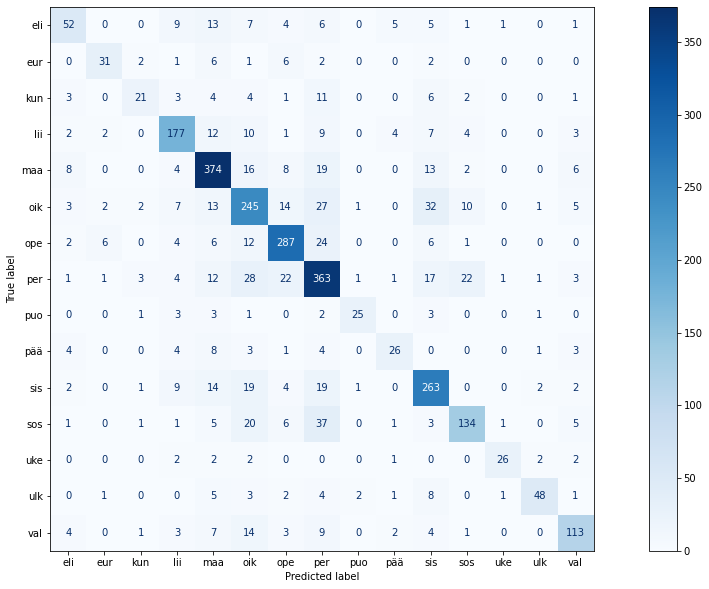

In [12]:
display_labels = [short_names[x] for x in enc.inverse_transform(clf.classes_)]
cm = confusion_matrix(y_test_true, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()